imports

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt

# Suppress ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)


## Check data

In [13]:
data = pd.read_csv('./data/clean_data.csv')

In [14]:
data.dropna(subset=['dob'], inplace=True)

data['c_jail_in'] = pd.to_datetime(data['c_jail_in'], format='%d/%m/%Y %H:%M', dayfirst=True)
data['c_jail_out'] = pd.to_datetime(data['c_jail_out'], format='%d/%m/%Y %H:%M', dayfirst=True)
data['dob'] = pd.to_datetime(data['dob'], format='%d/%m/%Y', dayfirst=True)
data['duration'] = abs((data['c_jail_out'] - data['c_jail_in']).dt.days) + 1
data['duration'] = data['duration'].fillna(0)
data['duration'] = data['duration'].astype('int')
df = data[data['is_recid'] != -1]
df_glob = df.drop(['id', 'sex', 'race', 'first', 'last', 'c_charge_desc', 'c_charge_degree', 'age_cat', 'c_jail_in', 'c_jail_out', 'age', 'dob', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'days_b_screening_arrest', 'c_days_from_compas', 'r_offense_date', 'r_charge_desc', 'r_jail_in','vr_offense_date','vr_charge_desc','score_text','screening_date','v_decile_score','v_score_text','priors_count.1', 'r_charge_degree', 'r_days_from_arrest', 'is_violent_recid', 'vr_charge_degree'], axis=1) 
df_glob.columns

Index(['decile_score', 'priors_count', 'is_recid', 'decile_score.1', 'event',
       'duration'],
      dtype='object')

In [15]:
sex_encoded = pd.get_dummies(data['sex'], prefix='sex')
age_encoded = pd.get_dummies(data['age_cat'], prefix='age_cat')
race_encoded = pd.get_dummies(data['race'], prefix='race')
c_degree_encoded = pd.get_dummies(data['c_charge_degree'], prefix='c_degree')
c_charge_desc_encoded = pd.get_dummies(data['c_charge_desc'], prefix='c_charge_desc')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df_glob, sex_encoded, race_encoded, c_degree_encoded, c_charge_desc_encoded], axis=1)
data.dropna(subset=['c_jail_in', 'c_jail_out'], inplace=True)

# Convert datetime objects to timestamps in seconds
df_encoded['dob'] = data['dob'].apply(lambda x: x.timestamp())
df_encoded['duration'] = abs((data['c_jail_out'] - data['c_jail_in']).dt.days)
df_encoded.dropna(inplace=True)
# df_encoded['c_jail_in'] = data['c_jail_in'].apply(lambda x: x.timestamp())
# df_encoded['c_jail_out'] = data['c_jail_out'].apply(lambda x: x.timestamp())
# df_encoded['r_offense_date'] = data['r_offense_date'].apply(lambda x: x.timestamp())
print(df_encoded.columns)
X = df_encoded.drop('is_recid', axis=1)
# df_encoded
X

Index(['decile_score', 'priors_count', 'is_recid', 'decile_score.1', 'event',
       'duration', 'sex_Female', 'sex_Male', 'race_African-American',
       'race_Asian',
       ...
       'c_charge_desc_Viol Injunction Protect Dom Vi',
       'c_charge_desc_Viol Pretrial Release Dom Viol',
       'c_charge_desc_Viol Prot Injunc Repeat Viol',
       'c_charge_desc_Violation License Restrictions',
       'c_charge_desc_Violation Of Boater Safety Id',
       'c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking',
       'c_charge_desc_Voyeurism', 'c_charge_desc_Workers Compensation Fraud',
       'c_charge_desc_arrest case no charge', 'dob'],
      dtype='object', length=542)


,decile_score,priors_count,decile_score.1,event,duration,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,...,c_charge_desc_Viol Injunction Protect Dom Vi,c_charge_desc_Viol Pretrial Release Dom Viol,c_charge_desc_Viol Prot Injunc Repeat Viol,c_charge_desc_Violation License Restrictions,c_charge_desc_Violation Of Boater Safety Id,c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc_Voyeurism,c_charge_desc_Workers Compensation Fraud,c_charge_desc_arrest case no charge,dob
0,1.0,0.0,1.0,0.0,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,-716601600.0
1,1.0,0.0,1.0,0.0,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,-716601600.0
3,3.0,0.0,3.0,1.0,10.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,380505600.0
4,4.0,4.0,4.0,0.0,1.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,674179200.0
5,4.0,4.0,4.0,0.0,1.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,674179200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,3.0,0.0,3.0,0.0,1.0,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,733017600.0
15509,6.0,5.0,6.0,0.0,10.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,472435200.0
15510,1.0,0.0,1.0,0.0,1.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,-355104000.0
15511,2.0,3.0,2.0,0.0,1.0,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,406339200.0


In [16]:
def get_accuracy(conf_matrix):
    return (conf_matrix[0][0] + conf_matrix[1][1]) / (conf_matrix[0].sum() + conf_matrix[1].sum())

In [17]:
preprocessor = StandardScaler()
# preprocessor = MinMaxScaler()
reductor = PCA(n_components=2)
algo = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(14, 14, 14, 14, 14, 14, 14, 14, 14, 14), random_state=1, max_iter=500)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reductor', reductor),
    ('algo', algo)
])

pipeline.fit(X, df_encoded['is_recid'])

cluster_labels = pipeline.predict(X)
cluster_series = pd.Series(cluster_labels, index=X.index)

data['cluster'] = cluster_series

y_true = df_encoded['is_recid']

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, cluster_labels)

print("Confusion Matrix:")
print(conf_matrix)

print(f"accuracy : {get_accuracy(conf_matrix)}")


Confusion Matrix:
[[5750 2114]
 [2736 3707]]
accuracy : 0.6610051023974278


In [18]:
def get_optimized_table(neuron_max, layer_max):
    res = []
    for layer in range(1, layer_max + 1):
        for neuron in range(1, neuron_max + 1):
            res.append(tuple([neuron for _ in range(layer)]))
    return res

In [19]:
iteration_function = []

def optimize(X, Y, neuron_max, layer_max, iteration_function):
    best_config = [(0,), 0]
    for n in get_optimized_table(neuron_max, layer_max):
        for _ in range(5):
            preprocessor = StandardScaler()
            reductor = PCA(n_components=2)
            algo = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15), random_state=1, max_iter=500)

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('reductor', reductor),
                ('algo', algo)
            ])

            pipeline.fit(X, Y)
            cluster_labels = pipeline.predict(X)
            cluster_series = pd.Series(cluster_labels, index=X.index)

            data['cluster'] = cluster_series

            # Compute the confusion matrix
            conf_matrix = confusion_matrix(Y, cluster_labels)

            iteration_function.append(get_accuracy(conf_matrix))
            if get_accuracy(conf_matrix) > best_config[1]:
                print(n)
                best_config = [n, get_accuracy(conf_matrix)]
    return best_config, iteration_function

In [20]:
best_config, iteration_function = optimize(X, df_encoded['is_recid'], 15, 10, iteration_function)
print(best_config)
print(iteration_function)

(1,)
(1,)
(2,)
(2,)
(5,)
(5, 5)
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
[(2, 2, 2, 2, 2, 2, 2, 2, 2, 2), 0.6584189557559237]
[0.6513594743831691, 0.6513594743831691, 0.6501712448451806, 0.6537359334591458, 0.6493324945830712, 0.6538757251694974, 0.6526175997763333, 0.6548542671419585, 0.649402390438247, 0.6527573914866849, 0.6533864541832669, 0.6508003075417628, 0.6521283287901027, 0.6512196826728175, 0.6498916614244775, 0.6491927028727197, 0.650380932410708, 0.6501013489900049, 0.6529670790522122, 0.6491228070175439, 0.6497518697141259, 0.6505207241210597, 0.6498217655693017, 0.650730411686587, 0.6549940588523101, 0.6527573914866849, 0.6508003075417628, 0.6527573914866849, 0.6526874956315091, 0.6510798909624659, 0.6508003075417628, 0.6494722862934228, 0.6524079122108059, 0.6493324945830712, 0.6510798909624659, 0.6505207241210597, 0.6473754106381492, 0.6503110365555322, 0.6491228070175439, 0.6521283287901027, 0.6527573914866849, 0.6521283287901027, 0.6494722862934228, 0.6527573914866849, 0.6477

In [4]:
best_config = (13, 13)
iteration_function_fixed = [0.6513594743831691, 0.6513594743831691, 0.6501712448451806, 0.6537359334591458, 0.6493324945830712, 0.6538757251694974, 0.6526175997763333, 0.6548542671419585, 0.649402390438247, 0.6527573914866849, 0.6533864541832669, 0.6508003075417628, 0.6521283287901027, 0.6512196826728175, 0.6498916614244775, 0.6491927028727197, 0.650380932410708, 0.6501013489900049, 0.6529670790522122, 0.6491228070175439, 0.6497518697141259, 0.6505207241210597, 0.6498217655693017, 0.650730411686587, 0.6549940588523101, 0.6527573914866849, 0.6508003075417628, 0.6527573914866849, 0.6526874956315091, 0.6510798909624659, 0.6508003075417628, 0.6494722862934228, 0.6524079122108059, 0.6493324945830712, 0.6510798909624659, 0.6505207241210597, 0.6473754106381492, 0.6503110365555322, 0.6491228070175439, 0.6521283287901027, 0.6527573914866849, 0.6521283287901027, 0.6494722862934228, 0.6527573914866849, 0.6477248899140281, 0.6527573914866849, 0.6500314531348291, 0.6510798909624659, 0.6517788495142238, 0.6520584329349269, 0.6518487453693996, 0.6522681205004544, 0.6514293702383449, 0.6521982246452785, 0.6548542671419585, 0.6533864541832669, 0.6519885370797511, 0.6505207241210597, 0.649402390438247, 0.6511497868176417, 0.6512196826728175, 0.6521283287901027, 0.6528272873418606, 0.6506605158314112, 0.6524778080659817, 0.6508003075417628, 0.6498916614244775, 0.6484238484657859, 0.6491228070175439, 0.6505906199762355, 0.6521982246452785, 0.6487034318864892, 0.6514992660935206, 0.6505906199762355, 0.6511497868176417, 0.654015516879849, 0.6518487453693996, 0.6510798909624659, 0.6527573914866849, 0.6534563500384427, 0.6516390578038722, 0.6515691619486964, 0.6491927028727197, 0.6499615572796533, 0.6492625987278955, 0.6491927028727197, 0.6518487453693996, 0.6529670790522122, 0.6524778080659817, 0.6510798909624659, 0.6510798909624659, 0.6525477039211575, 0.6515691619486964, 0.653036974907388, 0.6491927028727197, 0.6492625987278955, 0.6527573914866849, 0.6505207241210597, 0.6525477039211575, 0.6574404137834626, 0.6519885370797511, 0.650730411686587, 0.6502411407003564, 0.6513594743831691, 0.6533165583280911, 0.6511497868176417, 0.6511497868176417, 0.6498217655693017, 0.6529670790522122, 0.6508003075417628, 0.650730411686587, 0.651708953659048, 0.6501013489900049, 0.6535262458936185, 0.6512895785279933, 0.6514992660935206, 0.6547144754316069, 0.6500314531348291, 0.6524778080659817, 0.6524079122108059, 0.6491228070175439, 0.6494722862934228, 0.6519186412245754, 0.6518487453693996, 0.654015516879849, 0.6500314531348291, 0.6539456210246732, 0.6515691619486964, 0.6528971831970364, 0.6524079122108059, 0.6501712448451806, 0.6539456210246732, 0.6522681205004544, 0.6477947857692039, 0.6504508282658839, 0.6534563500384427, 0.6501013489900049, 0.6517788495142238, 0.6502411407003564, 0.6556930174040679, 0.6541553085902005, 0.6473055147829734, 0.6520584329349269, 0.6524778080659817, 0.6547843712867827, 0.6501712448451806, 0.651708953659048, 0.6500314531348291, 0.6489830153071923, 0.6512196826728175, 0.6557629132592437, 0.6497518697141259, 0.6486335360313134, 0.649402390438247, 0.6514293702383449, 0.6500314531348291, 0.6512196826728175, 0.6535262458936185, 0.6488432235968407, 0.6524778080659817, 0.6510798909624659, 0.6548542671419585, 0.6523380163556302, 0.6475152023485007, 0.6526175997763333, 0.6488432235968407, 0.6513594743831691, 0.6526874956315091, 0.6505207241210597, 0.6538058293143216, 0.6537359334591458, 0.653036974907388, 0.651708953659048, 0.6536660376039701, 0.6493324945830712, 0.6521283287901027, 0.6501712448451806, 0.6505906199762355, 0.6505207241210597, 0.6532466624729154, 0.6521283287901027, 0.6498916614244775, 0.654015516879849, 0.6504508282658839, 0.6509400992521144, 0.6501712448451806, 0.6542252044453764, 0.6506605158314112, 0.6521283287901027, 0.6490529111623681, 0.651708953659048, 0.6509400992521144, 0.6496120780037744, 0.650730411686587, 0.6514293702383449, 0.6510798909624659, 0.6524079122108059, 0.6527573914866849, 0.6529670790522122, 0.649402390438247, 0.649402390438247, 0.6519186412245754, 0.6498916614244775, 0.6514293702383449, 0.6502411407003564, 0.6496120780037744, 0.649402390438247, 0.6526874956315091, 0.6503110365555322, 0.6504508282658839, 0.6476549940588523, 0.6527573914866849, 0.6508702033969386, 0.6501013489900049, 0.6509400992521144, 0.6489830153071923, 0.6532466624729154, 0.6511497868176417, 0.6509400992521144, 0.649402390438247, 0.6531767666177396, 0.6498916614244775, 0.6509400992521144, 0.6524079122108059, 0.6531767666177396, 0.650380932410708, 0.6528272873418606, 0.6484238484657859, 0.6519186412245754, 0.6486335360313134, 0.6495421821485986, 0.6533864541832669, 0.6516390578038722, 0.6493324945830712, 0.6506605158314112, 0.6532466624729154, 0.6534563500384427, 0.6547144754316069, 0.650380932410708, 0.6519186412245754, 0.6519186412245754, 0.6493324945830712, 0.6544348920109038, 0.6515691619486964, 0.6519186412245754, 0.6492625987278955, 0.6510099951072902, 0.650380932410708, 0.6514992660935206, 0.6542252044453764, 0.6534563500384427, 0.6488432235968407, 0.6513594743831691, 0.6491927028727197, 0.6512196826728175, 0.6522681205004544, 0.6523380163556302, 0.6528971831970364, 0.6528272873418606, 0.653036974907388, 0.6512196826728175, 0.6504508282658839, 0.6534563500384427, 0.6515691619486964, 0.6510099951072902, 0.6525477039211575, 0.6504508282658839, 0.6512895785279933, 0.6489131194520165, 0.6522681205004544, 0.6535262458936185, 0.6500314531348291, 0.6505906199762355, 0.651708953659048, 0.6508003075417628, 0.6499615572796533, 0.6514992660935206, 0.6521283287901027, 0.6523380163556302, 0.6495421821485986, 0.6521283287901027, 0.6551338505626616, 0.651708953659048, 0.6497518697141259, 0.6514293702383449, 0.6529670790522122, 0.6520584329349269, 0.651708953659048, 0.6500314531348291, 0.6498916614244775, 0.6515691619486964, 0.6506605158314112, 0.6484238484657859, 0.6501712448451806, 0.6536660376039701, 0.6515691619486964, 0.6519186412245754, 0.6534563500384427, 0.6481442650450828, 0.6520584329349269, 0.6536660376039701, 0.648773327741665, 0.6514992660935206, 0.6502411407003564, 0.6549940588523101, 0.6536660376039701, 0.6521982246452785, 0.6518487453693996, 0.6522681205004544, 0.6532466624729154, 0.6508702033969386, 0.6522681205004544, 0.6528272873418606, 0.6536660376039701, 0.6528272873418606, 0.6525477039211575, 0.6480044733347312, 0.6523380163556302, 0.6483539526106102, 0.6508702033969386, 0.6505906199762355, 0.6506605158314112, 0.6523380163556302, 0.6532466624729154, 0.6495421821485986, 0.6511497868176417, 0.6545047878660796, 0.6523380163556302, 0.6514992660935206, 0.6533864541832669, 0.6512196826728175, 0.6534563500384427, 0.6501712448451806, 0.6506605158314112, 0.6512196826728175, 0.6532466624729154, 0.6536660376039701, 0.6514992660935206, 0.6484238484657859, 0.6470259313622703, 0.6526874956315091, 0.6521982246452785, 0.6537359334591458, 0.6515691619486964, 0.654364996155728, 0.6557629132592437, 0.6468861396519187, 0.6542951003005522, 0.6504508282658839, 0.6500314531348291, 0.6533864541832669, 0.6492625987278955, 0.6512895785279933, 0.6499615572796533, 0.6527573914866849, 0.6498217655693017, 0.6496819738589502, 0.6493324945830712, 0.6512895785279933, 0.6512895785279933, 0.6496819738589502, 0.6528971831970364, 0.6482840567554344, 0.6525477039211575, 0.650380932410708, 0.6519885370797511, 0.6506605158314112, 0.6524079122108059, 0.6505207241210597, 0.6505906199762355, 0.6508702033969386, 0.6473055147829734, 0.6499615572796533, 0.6506605158314112, 0.6519885370797511, 0.6502411407003564, 0.650380932410708, 0.6512895785279933, 0.650730411686587, 0.6509400992521144, 0.6520584329349269, 0.6501013489900049, 0.6484937443209617, 0.648773327741665, 0.6494722862934228, 0.6527573914866849, 0.6482840567554344, 0.6522681205004544, 0.6522681205004544, 0.6493324945830712, 0.6510798909624659, 0.6510099951072902, 0.6522681205004544, 0.6522681205004544, 0.6509400992521144, 0.6517788495142238, 0.6509400992521144, 0.6518487453693996, 0.6506605158314112, 0.6528272873418606, 0.6521283287901027, 0.6498217655693017, 0.6508003075417628, 0.6515691619486964, 0.6526874956315091, 0.6510798909624659, 0.647445306493325, 0.6508003075417628, 0.6526874956315091, 0.6512196826728175, 0.6475152023485007, 0.6512196826728175, 0.6519885370797511, 0.6539456210246732, 0.6508003075417628, 0.6500314531348291, 0.6514992660935206, 0.6498217655693017, 0.6468861396519187, 0.6544348920109038, 0.6524079122108059, 0.6512895785279933, 0.6524778080659817, 0.6528272873418606, 0.6509400992521144, 0.6536660376039701, 0.6515691619486964, 0.6517788495142238, 0.6533165583280911, 0.6490529111623681, 0.6489131194520165, 0.6513594743831691, 0.6491228070175439, 0.651708953659048, 0.6533864541832669, 0.6521283287901027, 0.6529670790522122, 0.651708953659048, 0.6516390578038722, 0.6519186412245754, 0.648773327741665, 0.6520584329349269, 0.6494722862934228, 0.6479345774795554, 0.6508003075417628, 0.6519186412245754, 0.651708953659048, 0.6491927028727197, 0.6526874956315091, 0.6517788495142238, 0.6472356189277976, 0.653036974907388, 0.6536660376039701, 0.6488432235968407, 0.6532466624729154, 0.6516390578038722, 0.6496819738589502, 0.6497518697141259, 0.6498916614244775, 0.6495421821485986, 0.6505207241210597, 0.6491228070175439, 0.6495421821485986, 0.6537359334591458, 0.6506605158314112, 0.6498217655693017, 0.6511497868176417, 0.6510798909624659, 0.6503110365555322, 0.6509400992521144, 0.6521283287901027, 0.6508003075417628, 0.6493324945830712, 0.6511497868176417, 0.6502411407003564, 0.6542252044453764, 0.6475850982036765, 0.6510099951072902, 0.6508003075417628, 0.6511497868176417, 0.6513594743831691, 0.6500314531348291, 0.6535961417487943, 0.6505906199762355, 0.6505906199762355, 0.6510099951072902, 0.6557629132592437, 0.653036974907388, 0.651708953659048, 0.655343538128189, 0.6483539526106102, 0.654015516879849, 0.6518487453693996, 0.6471657230726218, 0.647445306493325, 0.6514992660935206, 0.6540854127350249, 0.6481442650450828, 0.6478646816243797, 0.650730411686587, 0.6521982246452785, 0.6526874956315091, 0.6517788495142238, 0.6477248899140281, 0.6531068707625638, 0.6506605158314112, 0.6490529111623681, 0.6508702033969386, 0.6521283287901027, 0.6518487453693996, 0.653036974907388, 0.6510099951072902, 0.6511497868176417, 0.6484937443209617, 0.6490529111623681, 0.6535262458936185, 0.6498217655693017, 0.6518487453693996, 0.6521283287901027, 0.6526175997763333, 0.6524778080659817, 0.648074369189907, 0.6496819738589502, 0.6482840567554344, 0.650730411686587, 0.6526874956315091, 0.6473055147829734, 0.6516390578038722, 0.6521283287901027, 0.6482840567554344, 0.6520584329349269, 0.6544348920109038, 0.6548542671419585, 0.651708953659048, 0.6523380163556302, 0.6522681205004544, 0.6521283287901027, 0.6523380163556302, 0.6519885370797511, 0.6510099951072902, 0.6511497868176417, 0.6538757251694974, 0.6518487453693996, 0.6503110365555322, 0.6512196826728175, 0.6505906199762355, 0.6521283287901027, 0.6537359334591458, 0.6523380163556302, 0.6529670790522122, 0.650730411686587, 0.6509400992521144, 0.6512895785279933, 0.6446494722862934, 0.650380932410708, 0.6520584329349269, 0.6550639547074858, 0.6498916614244775, 0.6524778080659817, 0.6523380163556302, 0.6512895785279933, 0.6511497868176417, 0.6469560355070945, 0.6519885370797511, 0.6503110365555322, 0.6493324945830712, 0.6526874956315091, 0.6517788495142238, 0.6496120780037744, 0.6512196826728175, 0.6486335360313134, 0.6522681205004544, 0.6527573914866849, 0.6491927028727197, 0.6501712448451806, 0.6544348920109038, 0.6494722862934228, 0.6520584329349269, 0.6522681205004544, 0.6516390578038722, 0.6492625987278955, 0.6509400992521144, 0.6503110365555322, 0.6517788495142238, 0.6512895785279933, 0.6502411407003564, 0.6509400992521144, 0.6512895785279933, 0.6518487453693996, 0.6506605158314112, 0.6514992660935206, 0.6490529111623681, 0.6522681205004544, 0.6493324945830712, 0.6485636401761375, 0.6501712448451806, 0.6514992660935206, 0.6536660376039701, 0.6483539526106102, 0.6528272873418606, 0.6525477039211575, 0.6535262458936185, 0.6509400992521144, 0.6501013489900049, 0.6484937443209617, 0.6464667645208639, 0.6497518697141259, 0.6515691619486964, 0.6494722862934228, 0.6529670790522122, 0.6522681205004544, 0.6505207241210597, 0.6508702033969386, 0.6552736422730132, 0.6519186412245754, 0.6514293702383449, 0.6502411407003564, 0.6518487453693996, 0.6491927028727197, 0.6529670790522122, 0.6526175997763333, 0.6555532256937163, 0.6529670790522122, 0.6522681205004544, 0.6531068707625638, 0.6508003075417628, 0.649402390438247, 0.6489830153071923, 0.650730411686587, 0.6532466624729154, 0.6503110365555322, 0.6463269728105123, 0.6509400992521144, 0.6508702033969386, 0.6514992660935206, 0.6515691619486964, 0.6531068707625638, 0.6525477039211575, 0.6528971831970364, 0.6514992660935206, 0.6509400992521144, 0.648074369189907, 0.6531767666177396, 0.6533864541832669, 0.6519186412245754, 0.650730411686587, 0.6517788495142238, 0.6505207241210597, 0.6499615572796533, 0.6505207241210597, 0.6489131194520165, 0.6505207241210597, 0.6505906199762355, 0.6491927028727197, 0.6489830153071923, 0.6518487453693996, 0.6522681205004544, 0.6505906199762355, 0.6517788495142238, 0.6488432235968407, 0.6505207241210597, 0.6498217655693017, 0.6500314531348291, 0.6514293702383449, 0.6518487453693996, 0.650730411686587, 0.6508702033969386, 0.650380932410708, 0.6514992660935206, 0.6535262458936185, 0.6537359334591458, 0.6501712448451806, 0.6482141609002586, 0.6510099951072902, 0.6512895785279933, 0.6521982246452785, 0.6496120780037744, 0.650380932410708, 0.6513594743831691, 0.6501013489900049, 0.6584189557559237, 0.6527573914866849, 0.650380932410708, 0.6535961417487943, 0.6502411407003564, 0.6538757251694974, 0.6528971831970364, 0.6521283287901027, 0.6511497868176417, 0.6499615572796533, 0.6491228070175439, 0.6497518697141259, 0.646746347941567, 0.6510099951072902, 0.651708953659048, 0.6516390578038722, 0.6491228070175439, 0.6505906199762355, 0.6496819738589502, 0.6493324945830712, 0.6509400992521144, 0.6481442650450828, 0.6490529111623681, 0.6528971831970364, 0.6508003075417628, 0.6513594743831691, 0.6545047878660796, 0.6513594743831691, 0.6517788495142238, 0.6503110365555322, 0.6542951003005522, 0.6544348920109038, 0.650730411686587, 0.6554134339833648, 0.6480044733347312, 0.6526874956315091, 0.651708953659048, 0.6539456210246732, 0.654015516879849, 0.6496819738589502, 0.6547144754316069, 0.6541553085902005, 0.6527573914866849, 0.6531068707625638, 0.6490529111623681, 0.6542252044453764, 0.6518487453693996, 0.6521982246452785, 0.6508702033969386, 0.6534563500384427, 0.6499615572796533, 0.6488432235968407, 0.6519885370797511, 0.6498217655693017, 0.6525477039211575, 0.6536660376039701, 0.6524079122108059, 0.6512196826728175, 0.6501013489900049, 0.6512895785279933, 0.6516390578038722, 0.6521283287901027, 0.6515691619486964, 0.6510099951072902, 0.6503110365555322, 0.6516390578038722, 0.6523380163556302, 0.6510099951072902, 0.6540854127350249, 0.6506605158314112]

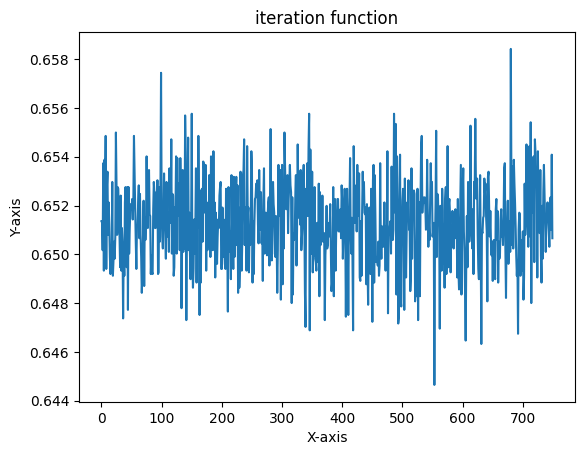

In [5]:
plt.plot(iteration_function_fixed)

plt.xlabel('nb iterations')
plt.ylabel('accuracy')
plt.title('iteration function')

plt.show()

In [22]:
preprocessor = StandardScaler()
# preprocessor = MinMaxScaler()
reductor = PCA(n_components=2)
algo = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=best_config, random_state=1, max_iter=500)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reductor', reductor),
    ('algo', algo)
])

X_train, X_test, y_train, y_test = train_test_split(X, df_encoded['is_recid'], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred_tot = pipeline.predict(X)

cluster_series = pd.Series(y_pred_tot, index=X.index)

conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

data['prediction'] = cluster_series

data.to_csv("data/prediction_with_neural.csv")

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69      1585
         1.0       0.62      0.60      0.61      1277

    accuracy                           0.66      2862
   macro avg       0.65      0.65      0.65      2862
weighted avg       0.66      0.66      0.66      2862

Confusion Matrix:
[[1114  471]
 [ 513  764]]
